In [33]:
%load_ext nb_black
import sys
import warnings

# add pathway to config files
sys.path.append("../")

import copy
import joblib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
import cartopy.crs as ccrs


# import MAGICC tools
import scmdata
import scmdata.database

# import MESMER tools
from mesmer.io import load_cmipng, load_mesmer_output, load_obs, load_regs_ls_wgt_lon_lat
from mesmer.utils import convert_dict_to_arr, extract_land

# load in configurations used in this script
import configs.config_across_scen_T_cmip6ng_sspall_default as cfg


The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

# Load in all the necessary data

In [34]:
print('Specify what is looked at')
magicc_scenarios_to_run=["ssp*"]
time = np.arange(1850,2101)
scenarios_sel = ['h-ssp370','h-ssp119']
q = [0.05,0.5,0.95] #quantiles to derive
esms = cfg.esms
nr_esms = len(esms)
esms_sel = ['CanESM5','MPI-ESM1-2-LR','IPSL-CM6A-LR']


Specify what is looked at


<IPython.core.display.Javascript object>

In [35]:
print("Load in MAGICC output")
db = scmdata.database.ScmDatabase(cfg.dir_magicc_probab_emus)
magicc_co2_conc = scmdata.run_append(
    [
        db.load(scenario=s, variable="Atmospheric Concentrations CO2")
        for s in magicc_scenarios_to_run
    ]
)
magicc_gsat_output = scmdata.run_append(
    [
        db.load(scenario=s, variable="Surface Air Temperature Change")
        for s in magicc_scenarios_to_run
    ]
)

print("Preprocess MAGICC CO2 concentaration output")
# ATTENTION: requires scmdata v>0.9.0 and <0.10.0, otherwise time filter doesn't work

co2_conc = {}
for scen in scenarios_sel:
    # cut out 1850-2100
    co2_conc[scen] = magicc_co2_conc.filter(scenario=scen[2:], year=time).values[0]
    # same CO2 conc in every MAGICC run since these are conc-driven runs

print("Preprocess MAGICC probabilistic forced warming output")
# ATTENTION: requires scmdata v>0.9.0 and <0.10.0, otherwise time filter doesn't work
gt_T = {}
for scen in scenarios_sel:
    # cut out 1850-2100
    gt_T[scen] = magicc_gsat_output.filter(scenario=scen[2:], year=time).values
    # rebaseline to 1850-1900
    gt_T[scen] = gt_T[scen] - np.mean(gt_T[scen][:, :51], axis=1).reshape([600, 1])

Load in MAGICC output


Loading files:   0%|          | 0/8 [00:00<?, ?it/s]

/net/cfc/landclim1/beuschl/conda/envs/magicc-mesmer/lib/python3.8/site-packages/scmdata/netcdf.py:201: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dims["time"] = _read_time_variable(ds.variables["time"])


Loading files:   0%|          | 0/8 [00:00<?, ?it/s]

Preprocess MAGICC CO2 concentaration output
Preprocess MAGICC probabilistic forced warming output


<IPython.core.display.Javascript object>

In [36]:
print("Load in MESMER parameters of all ESMs")
params_lt = {}
for esm in esms:
    params_lt[esm] = load_mesmer_output("params_lt", cfg, esm_str=esm)

Load in MESMER parameters of all ESMs


<IPython.core.display.Javascript object>

In [37]:
print('Load in the local variability emulations of the selected ESMs')
emus_lv={}
for esm in esms_sel:
    print('start loading',esm)
    emus_lv[esm] = load_mesmer_output('emus_lv',cfg,esm_str=esm)


Load in the local variability emulations of the selected ESMs
start loading CanESM5
start loading MPI-ESM1-2-LR
start loading IPSL-CM6A-LR


<IPython.core.display.Javascript object>

In [38]:
print('Load in the MAGICC-MESMER output')

print('Load in the global emulation quantiles')
reg = 'global'
emu_g_q = joblib.load(cfg.dir_stats+reg+'_quantiles.pkl')


print('Load in the spatial maps of the grid-point-level quantiles')
emu_q={}
emu_q[2014]={}
emu_q[2014]['h-ssp245']={}
# 2014 is in historical period -> same values for each scen -> computed on h-ssp245 here, but could take from any
for q_sel in q:
    emu_q[2014]['h-ssp245'][q_sel]=joblib.load(cfg.dir_stats+'gp_level/fields/2014_quantile'+str(q_sel)+'_h-ssp245.pkl')

years = [2050,2100]
for year in years:
    emu_q[year]={}
    for scen in scenarios_sel:
        emu_q[year][scen]={}
        for q_sel in q:
            emu_q[year][scen][q_sel]=joblib.load(cfg.dir_stats+f'gp_level/fields/{year}_quantile{q_sel}_{scen}.pkl')
            
print('Load in the ENA-gp emulation quantiles (including all sources of uncertainty)')
idx_gp = 1317
gp_q={}
gp_q['full']=joblib.load(cfg.dir_stats+'gp_level/'+str(idx_gp)+'_quantiles.pkl')



Load in the MAGICC-MESMER output
Load in the global emulation quantiles
Load in the spatial maps of the grid-point-level quantiles
Load in the ENA-gp emulation quantiles (including all sources of uncertainty)


<IPython.core.display.Javascript object>

In [39]:
print(
    "Load in a CMIP6 run to obtain the geographical land-sea information needed to plot maps"
)
# Due to the way the loading in currently works, this unfortuantely has to load in quite some
# unnecessary variables too. But this is just a "cosmetic" issue as not a lot of time / memory
# space is needed


# specify the target variable
targ = cfg.targs[0]
print(targ)

# load in the ESM runs
esms_subsel = [cfg.esms[0]]

# load in tas with global coverage
tas_g_dict = {}  # tas with global coverage
GSAT_dict = {}  # global mean tas
tas_g = {}
GSAT = {}

for esm in esms_subsel:
    print(esm)
    tas_g_dict[esm] = {}
    GSAT_dict[esm] = {}

    for scen in scenarios_sel:

        tas_g_tmp, GSAT_tmp, lon_tmp, lat_tmp, time_tmp = load_cmipng(
            targ, esm, scen, cfg
        )

        if tas_g_tmp is None:
            warnings.warn(f"Scenario {scen} does not exist for tas for ESM {esm}")
        else:  # if scen exists: save fields
            tas_g_dict[esm][scen], GSAT_dict[esm][scen], lon, lat, _ = (
                tas_g_tmp,
                GSAT_tmp,
                lon_tmp,
                lat_tmp,
                time_tmp,
            )

    tas_g[esm] = convert_dict_to_arr(tas_g_dict[esm])
    GSAT[esm] = convert_dict_to_arr(GSAT_dict[esm])

# load in the constant files
reg_dict, ls, wgt_g, lon, lat = load_regs_ls_wgt_lon_lat(cfg.reg_type, lon, lat)

# extract land
tas, reg_dict, ls = extract_land(
    tas_g, reg_dict, wgt_g, ls, threshold_land=cfg.threshold_land
)

Load in a CMIP6 run to obtain the geographical land-sea information needed to plot maps
tas
ACCESS-CM2


/tmp/ipykernel_34646/2093624348.py:34: UserWarning: Scenario h-ssp119 does not exist for tas for ESM ACCESS-CM2
  warnings.warn(f"Scenario {scen} does not exist for tas for ESM {esm}")


<IPython.core.display.Javascript object>

# Figure 1 subplots

In [40]:
print("Specify the colors")
col = {}
col["h-ssp119"] = "#0571b0"
col["h-ssp370"] = "#ca0020"

Specify the colors


<IPython.core.display.Javascript object>

Plot the CO2 subplot


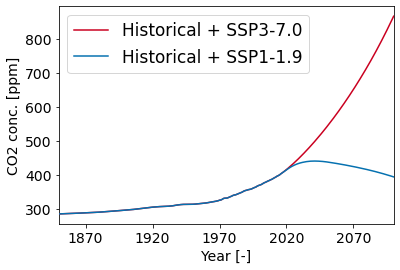

<IPython.core.display.Javascript object>

In [41]:
print("Plot the CO2 subplot")
fig = plt.figure(figsize=(6, 4))
plt.rcParams.update({"font.size": 14})


scen1 = "h-ssp370"
plt.plot(time, co2_conc[scen1], zorder=101, color=col[scen1])
scen2 = "h-ssp119"
plt.plot(time, co2_conc[scen2], zorder=103, color=col[scen2])


plt.xlim([1850, 2100])
plt.xticks(np.arange(1870, 2100, 50))
plt.ylabel("CO2 conc. [ppm]")
plt.xlabel("Year [-]")
custom_lines = [Line2D([0], [0], color=col[scen1]), Line2D([0], [0], color=col[scen2])]
plt.legend(
    custom_lines, ["Historical + SSP3-7.0", "Historical + SSP1-1.9"], loc=2, fontsize=17
)

#plt.savefig(cfg.dir_plots+f'ts_co2_conc_{scen1}_{scen2}.png' ,dpi=200 ,bbox_inches='tight')

Plot the global temperature subplot


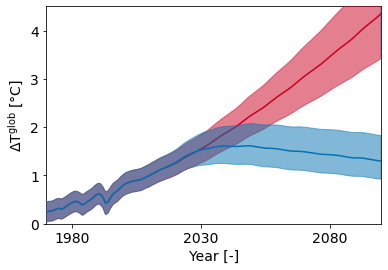

<IPython.core.display.Javascript object>

In [42]:
print('Plot the global temperature subplot')
fig=plt.figure(figsize=(6, 4))
plt.rcParams.update({'mathtext.default':'regular'}) 

plt.rcParams.update({'font.size': 14})

reg='global'
time_plt = np.arange(1850,2101)

scen1='h-ssp370'
plt.plot(time,emu_g_q[scen1][0.5],zorder=101,color=col[scen1])
plt.fill_between(time,emu_g_q[scen1][0.05],emu_g_q[scen1][0.95],alpha=0.5,zorder=100,color=col[scen1])

scen2='h-ssp119'
plt.plot(time,emu_g_q[scen2][0.5],zorder=103,color=col[scen2])
plt.fill_between(time,emu_g_q[scen2][0.05],emu_g_q[scen2][0.95],alpha=0.5,zorder=102,color=col[scen2])


plt.xlim([1970,2100])
plt.xticks(np.arange(1980,2100,50))
plt.ylim([0,4.5])
plt.ylabel('$\Delta T^{glob}$ [°C]')
plt.xlabel('Year [-]');

#plt.savefig(cfg.dir_plots+f'ts_emu_GSAT_{scen1}_{scen2}.png' ,dpi=200 ,bbox_inches='tight')


Plot the spatial maps


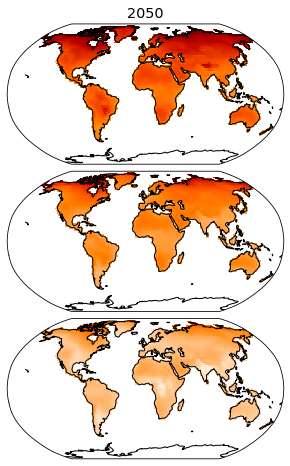

<IPython.core.display.Javascript object>

In [43]:
print('Plot the spatial maps')
plt.figure(figsize=(8, 8))
plt.rcParams.update({'mathtext.default':'it'}) 
plt.rcParams.update({'font.size':12})

grid = plt.GridSpec(3, 1, wspace=0.1, hspace=0.05) # create a grid for the subplots

vmin=0
vmax=12
cmap='gist_heat_r'


# Manually change year & scen to obtain all necessary maps
year=2050 # 2014, 2050, 2100
scen='h-ssp370' # h-ssp119, h-ssp245, h-ssp370

q_r = [0.95,0.5,0.05]
for i,q_sel in enumerate(q_r):
    y_ma=copy.deepcopy(ls['grid_l_m'])
    y_ma[ls['idx_grid_l']]=emu_q[year][scen][q_sel]
    ax1 = plt.subplot(grid[i,0], projection=ccrs.Robinson(central_longitude=0))
    ax1.coastlines()
    mesh_1=ax1.pcolormesh(lon['e'], lat['e'],y_ma,cmap=cmap,vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree(),rasterized=True)
    mesh_1.cmap.set_under('#d1e5f0')
    if i == 0:
        plt.title(year)

#plt.savefig(cfg.dir_plots+f'{year}_maps_quantiles_{scen}.png' ,dpi=200 ,bbox_inches='tight')



Plot the colorbar for the spatial maps


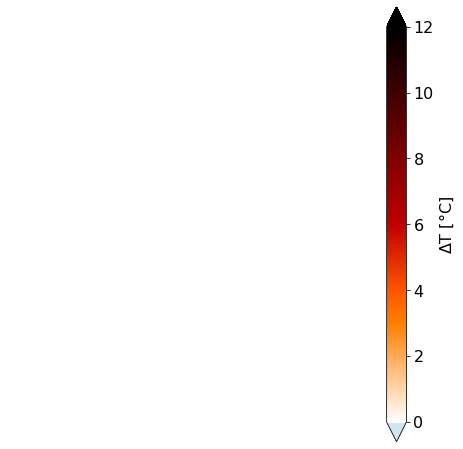

<IPython.core.display.Javascript object>

In [44]:
print('Plot the colorbar for the spatial maps')
plt.figure(figsize=(8, 8))
plt.rcParams.update({'mathtext.default':'it'}) 
plt.rcParams.update({'font.size':16})

grid = plt.GridSpec(1, 1, wspace=0.1, hspace=0.05) # create a grid for the subplots
plt.axis('off')
mesh_1.cmap.set_under('#d1e5f0')
cbar=plt.colorbar(mesh_1,extend='both')
cbar.set_label('$\Delta$T [°C]')

#plt.savefig(cfg.dir_plots+'maps_quantiles_colorbar.png' ,dpi=200 ,bbox_inches='tight')


# Figure 2 raw plot

In [45]:
print("Specify Figure 2 specific information")
nr_samples = 4
idx_iv = [0, 150, 20, 3]
idx_glob = [50, 320]
uncs = ["no_iv_reg_glob", "no_iv_reg", "no_iv", "full"]  # different uncertainty ranges
names = [
    "No\nunc. $\Delta$T [°C]",
    "Plus glob. resp.\nunc. $\Delta$T [°C]",
    "Plus reg. resp.\nunc. $\Delta$T [°C]",
    "Plus int. var.\nunc. $\Delta$T [°C]",
]
cols = ["#e7298a", "#7570b3", "#d95f02", "#1b9e77"]

Specify Figure 2 specific information


<IPython.core.display.Javascript object>

In [46]:
print("Compute grid-point-level the quantiles without internal variability")
gp_q["no_iv"] = {}  # no internal variability
for scen in scenarios_sel:
    print("start with scenario:", scen)
    gp_q["no_iv"][scen] = {}
    nr_gt_T, nr_ts = gt_T[scen].shape
    nr_emus_per_esm = nr_gt_T  # since this is only about the forced response
    gp_all = np.zeros([nr_emus_per_esm * nr_esms, nr_ts])
    for s, esm in enumerate(esms):
        gp_all[s * nr_emus_per_esm : s * nr_emus_per_esm + nr_emus_per_esm] = (
            params_lt[esm]["coef_gttas"]["tas"][idx_gp] * gt_T[scen]
            + params_lt[esm]["intercept"]["tas"][idx_gp]
        )

    (
        gp_q["no_iv"][scen][q[0]],
        gp_q["no_iv"][scen][q[1]],
        gp_q["no_iv"][scen][q[2]],
    ) = np.quantile(gp_all, q=q, axis=0)

Compute grid-point-level the quantiles without internal variability
start with scenario: h-ssp370
start with scenario: h-ssp119


<IPython.core.display.Javascript object>

In [47]:
print('Compute grid-point-level the quantiles without internal variability and regional differences')
idx_esm=esms.index(esms_sel[1])
print(esms[idx_esm])

gp_q['no_iv_reg']={} # no internal variability, no differences in reg scaling
for scen in scenarios_sel:
    print('start with scenario:',scen)
    gp_q['no_iv_reg'][scen]={}
    nr_gt_T,nr_ts = gt_T[scen].shape
    nr_emus_per_esm = nr_gt_T
    gp_all = np.zeros([nr_emus_per_esm*nr_esms,nr_ts])
    for s,esm in enumerate(esms):
        gp_all[s*nr_emus_per_esm:s*nr_emus_per_esm+nr_emus_per_esm]=params_lt[esms[idx_esm]]["coef_gttas"]['tas'][idx_gp]*gt_T[scen]+params_lt[esms[idx_esm]]['intercept']['tas'][idx_gp]
   
    gp_q['no_iv_reg'][scen][q[0]],gp_q['no_iv_reg'][scen][q[1]],gp_q['no_iv_reg'][scen][q[2]]= np.quantile(gp_all,q=q,axis=0)


Compute grid-point-level the quantiles without internal variability and regional differences
MPI-ESM1-2-LR
start with scenario: h-ssp370
start with scenario: h-ssp119


<IPython.core.display.Javascript object>

In [48]:
print(
    "Compute grid-point-level the quantiles without internal variability, regional differences, and global fr response differences"
)
idx_gt_T = idx_glob[1]
print(esms[idx_esm])

gp_q[
    "no_iv_reg_glob"
] = {}  # no internal variability, no diff in reg scaling, no diff in glob fr response
for scen in scenarios_sel:
    print("start with scenario:", scen)
    gp_q["no_iv_reg_glob"][scen] = {}
    nr_gt_T, nr_ts = gt_T[scen].shape
    nr_emus_per_esm = nr_gt_T
    gp_all = np.zeros([nr_emus_per_esm * nr_esms, nr_ts])
    for s, esm in enumerate(esms):
        gp_all[s * nr_emus_per_esm : s * nr_emus_per_esm + nr_emus_per_esm] = (
            params_lt[esms[idx_esm]]["coef_gttas"]["tas"][idx_gp] * gt_T[scen][idx_gt_T]
            + params_lt[esms[idx_esm]]["intercept"]["tas"][idx_gp]
        )

    (
        gp_q["no_iv_reg_glob"][scen][q[0]],
        gp_q["no_iv_reg_glob"][scen][q[1]],
        gp_q["no_iv_reg_glob"][scen][q[2]],
    ) = np.quantile(gp_all, q=q, axis=0)

Compute grid-point-level the quantiles without internal variability, regional differences, and global fr response differences
MPI-ESM1-2-LR
start with scenario: h-ssp370
start with scenario: h-ssp119


<IPython.core.display.Javascript object>

In [49]:
print(
    "Compute grid-point-level sample realizations to visualize the uncertainties taken into account"
)
# 0: iv:C, reg:C, g=50
# 1: iv:C, reg:C, g=50
# 2: iv:M, reg: M, g=50
# 3: iv:I, reg: I, g=320

gp_samples = {}
gp_samples["full"] = {}
gp_samples["no_iv"] = {}
gp_samples["no_iv_reg"] = {}
gp_samples["no_iv_reg_glob"] = {}

for scen in scenarios_sel:
    gp_samples["full"][scen] = np.zeros([nr_samples, nr_ts])
    gp_samples["full"][scen][0] = (
        params_lt[esms_sel[0]]["coef_gttas"]["tas"][idx_gp] * gt_T[scen][idx_glob[0]]
        + params_lt[esms_sel[0]]["intercept"]["tas"][idx_gp]
        + emus_lv[esms_sel[0]]["all"]["tas"][idx_iv[0], :, idx_gp]
    )
    gp_samples["full"][scen][1] = (
        params_lt[esms_sel[0]]["coef_gttas"]["tas"][idx_gp] * gt_T[scen][idx_glob[0]]
        + params_lt[esms_sel[0]]["intercept"]["tas"][idx_gp]
        + emus_lv[esms_sel[0]]["all"]["tas"][idx_iv[1], :, idx_gp]
    )
    gp_samples["full"][scen][2] = (
        params_lt[esms_sel[1]]["coef_gttas"]["tas"][idx_gp] * gt_T[scen][idx_glob[0]]
        + params_lt[esms_sel[1]]["intercept"]["tas"][idx_gp]
        + emus_lv[esms_sel[1]]["all"]["tas"][idx_iv[2], :, idx_gp]
    )
    gp_samples["full"][scen][3] = (
        params_lt[esms_sel[2]]["coef_gttas"]["tas"][idx_gp] * gt_T[scen][idx_glob[1]]
        + params_lt[esms_sel[2]]["intercept"]["tas"][idx_gp]
        + emus_lv[esms_sel[2]]["all"]["tas"][idx_iv[3], :, idx_gp]
    )

    gp_samples["no_iv"][scen] = np.zeros([nr_samples, nr_ts])
    gp_samples["no_iv"][scen][0] = (
        params_lt[esms_sel[0]]["coef_gttas"]["tas"][idx_gp] * gt_T[scen][idx_glob[0]]
        + params_lt[esms_sel[0]]["intercept"]["tas"][idx_gp]
    )
    gp_samples["no_iv"][scen][1] = (
        params_lt[esms_sel[0]]["coef_gttas"]["tas"][idx_gp] * gt_T[scen][idx_glob[0]]
        + params_lt[esms_sel[0]]["intercept"]["tas"][idx_gp]
    )
    gp_samples["no_iv"][scen][2] = (
        params_lt[esms_sel[1]]["coef_gttas"]["tas"][idx_gp] * gt_T[scen][idx_glob[0]]
        + params_lt[esms_sel[1]]["intercept"]["tas"][idx_gp]
    )
    gp_samples["no_iv"][scen][3] = (
        params_lt[esms_sel[2]]["coef_gttas"]["tas"][idx_gp] * gt_T[scen][idx_glob[1]]
        + params_lt[esms_sel[2]]["intercept"]["tas"][idx_gp]
    )

    gp_samples["no_iv_reg"][scen] = np.zeros([nr_samples, nr_ts])
    gp_samples["no_iv_reg"][scen][0] = (
        params_lt[esms_sel[1]]["coef_gttas"]["tas"][idx_gp] * gt_T[scen][idx_glob[0]]
        + params_lt[esms_sel[1]]["intercept"]["tas"][idx_gp]
    )
    gp_samples["no_iv_reg"][scen][1] = (
        params_lt[esms_sel[1]]["coef_gttas"]["tas"][idx_gp] * gt_T[scen][idx_glob[0]]
        + params_lt[esms_sel[1]]["intercept"]["tas"][idx_gp]
    )
    gp_samples["no_iv_reg"][scen][2] = (
        params_lt[esms_sel[1]]["coef_gttas"]["tas"][idx_gp] * gt_T[scen][idx_glob[0]]
        + params_lt[esms_sel[1]]["intercept"]["tas"][idx_gp]
    )
    gp_samples["no_iv_reg"][scen][3] = (
        params_lt[esms_sel[1]]["coef_gttas"]["tas"][idx_gp] * gt_T[scen][idx_glob[1]]
        + params_lt[esms_sel[1]]["intercept"]["tas"][idx_gp]
    )

    gp_samples["no_iv_reg_glob"][scen] = np.zeros([nr_samples, nr_ts])
    gp_samples["no_iv_reg_glob"][scen][0] = (
        params_lt[esms_sel[1]]["coef_gttas"]["tas"][idx_gp] * gt_T[scen][idx_glob[1]]
        + params_lt[esms_sel[1]]["intercept"]["tas"][idx_gp]
    )
    gp_samples["no_iv_reg_glob"][scen][1] = (
        params_lt[esms_sel[1]]["coef_gttas"]["tas"][idx_gp] * gt_T[scen][idx_glob[1]]
        + params_lt[esms_sel[1]]["intercept"]["tas"][idx_gp]
    )
    gp_samples["no_iv_reg_glob"][scen][2] = (
        params_lt[esms_sel[1]]["coef_gttas"]["tas"][idx_gp] * gt_T[scen][idx_glob[1]]
        + params_lt[esms_sel[1]]["intercept"]["tas"][idx_gp]
    )
    gp_samples["no_iv_reg_glob"][scen][3] = (
        params_lt[esms_sel[1]]["coef_gttas"]["tas"][idx_gp] * gt_T[scen][idx_glob[1]]
        + params_lt[esms_sel[1]]["intercept"]["tas"][idx_gp]
    )

Compute grid-point-level sample realizations to visualize the uncertainties taken into account


<IPython.core.display.Javascript object>

In [50]:
print('Compute maps of sample realizations to visualize the uncertainties taken into account')


idx_t = np.where(time == 2030)[0][0]

map_samples = {}

map_samples['full'] = {}
map_samples['no_iv'] = {}
map_samples['no_iv_reg'] = {}
map_samples ['no_iv_reg_glob'] = {}


nr_gps=params_lt[esms_sel[0]]["coef_gttas"]['tas'].shape[0]

for scen in scenarios_sel:
    map_samples['full'][scen]=np.zeros([nr_samples,nr_gps])
    map_samples['full'][scen][0] = params_lt[esms_sel[0]]["coef_gttas"]['tas']*gt_T[scen][idx_glob[0],idx_t]+params_lt[esms_sel[0]]['intercept']['tas']+emus_lv[esms_sel[0]]['all']['tas'][idx_iv[0],idx_t]
    map_samples['full'][scen][1] = params_lt[esms_sel[0]]["coef_gttas"]['tas']*gt_T[scen][idx_glob[0],idx_t]+params_lt[esms_sel[0]]['intercept']['tas']+emus_lv[esms_sel[0]]['all']['tas'][idx_iv[1],idx_t]
    map_samples['full'][scen][2] = params_lt[esms_sel[1]]["coef_gttas"]['tas']*gt_T[scen][idx_glob[0],idx_t]+params_lt[esms_sel[1]]['intercept']['tas']+emus_lv[esms_sel[1]]['all']['tas'][idx_iv[2],idx_t]
    map_samples['full'][scen][3] = params_lt[esms_sel[2]]["coef_gttas"]['tas']*gt_T[scen][idx_glob[1],idx_t]+params_lt[esms_sel[2]]['intercept']['tas']+emus_lv[esms_sel[2]]['all']['tas'][idx_iv[3],idx_t]

    map_samples['no_iv'][scen]=np.zeros([nr_samples,nr_gps])
    map_samples['no_iv'][scen][0] = params_lt[esms_sel[0]]["coef_gttas"]['tas']*gt_T[scen][idx_glob[0],idx_t]+params_lt[esms_sel[0]]['intercept']['tas']
    map_samples['no_iv'][scen][1] = params_lt[esms_sel[0]]["coef_gttas"]['tas']*gt_T[scen][idx_glob[0],idx_t]+params_lt[esms_sel[0]]['intercept']['tas']
    map_samples['no_iv'][scen][2] = params_lt[esms_sel[1]]["coef_gttas"]['tas']*gt_T[scen][idx_glob[0],idx_t]+params_lt[esms_sel[1]]['intercept']['tas']
    map_samples['no_iv'][scen][3] = params_lt[esms_sel[2]]["coef_gttas"]['tas']*gt_T[scen][idx_glob[1],idx_t]+params_lt[esms_sel[2]]['intercept']['tas']

    map_samples['no_iv_reg'][scen]=np.zeros([nr_samples,nr_gps])
    map_samples['no_iv_reg'][scen][0] = params_lt[esms_sel[1]]["coef_gttas"]['tas']*gt_T[scen][idx_glob[0],idx_t]+params_lt[esms_sel[1]]['intercept']['tas']
    map_samples['no_iv_reg'][scen][1] = params_lt[esms_sel[1]]["coef_gttas"]['tas']*gt_T[scen][idx_glob[0],idx_t]+params_lt[esms_sel[1]]['intercept']['tas']
    map_samples['no_iv_reg'][scen][2] = params_lt[esms_sel[1]]["coef_gttas"]['tas']*gt_T[scen][idx_glob[0],idx_t]+params_lt[esms_sel[1]]['intercept']['tas']
    map_samples['no_iv_reg'][scen][3] = params_lt[esms_sel[1]]["coef_gttas"]['tas']*gt_T[scen][idx_glob[1],idx_t]+params_lt[esms_sel[1]]['intercept']['tas']

    
    map_samples['no_iv_reg_glob'][scen]=np.zeros([nr_samples,nr_gps])
    map_samples['no_iv_reg_glob'][scen][0] = params_lt[esms_sel[1]]["coef_gttas"]['tas']*gt_T[scen][idx_glob[1],idx_t]+params_lt[esms_sel[1]]['intercept']['tas']
    map_samples['no_iv_reg_glob'][scen][1] = params_lt[esms_sel[1]]["coef_gttas"]['tas']*gt_T[scen][idx_glob[1],idx_t]+params_lt[esms_sel[1]]['intercept']['tas']
    map_samples['no_iv_reg_glob'][scen][2] = params_lt[esms_sel[1]]["coef_gttas"]['tas']*gt_T[scen][idx_glob[1],idx_t]+params_lt[esms_sel[1]]['intercept']['tas']
    map_samples['no_iv_reg_glob'][scen][3] = params_lt[esms_sel[1]]["coef_gttas"]['tas']*gt_T[scen][idx_glob[1],idx_t]+params_lt[esms_sel[1]]['intercept']['tas']


Compute maps of sample realizations to visualize the uncertainties taken into account


<IPython.core.display.Javascript object>

In [51]:
def plot_ts():
    ax1 = plt.subplot(grid[l, m : m + 2])

    plt.axvline(2030, color="#8ab8fe", lw=1)
    for i in np.arange(4):
        plt.plot(time, gp_samples[unc][scen][i], color=cols[i], zorder=i, lw=1.5,alpha=0.6)

    plt.plot(time, gp_q[unc][scen][0.5], zorder=101, color="k",lw=0.9,alpha=0.8) ##3c4142
    plt.fill_between(
        time,
        gp_q[unc][scen][0.05],
        gp_q[unc][scen][0.95],
        alpha=1,
        zorder=-100,
        facecolor="lightgrey",
        edgecolor=None,
    )

    plt.xticks(np.arange(1870, 2101, 100))
    plt.xlim([time[0], time[-1]])
    plt.ylim([-2.2, 4.4])

    ax1.yaxis.set_ticks_position("both")

    plt.ylabel(name)


def plot_map():
    vmin = 0
    vmax = 4.5
    cmap = "gist_heat_r"

    y_ma = copy.deepcopy(ls["grid_l_m"])
    y_ma[ls["idx_grid_l"]] = map_samples[unc][scen][m]
    ax1.coastlines()
    mesh_1 = ax1.pcolormesh(
        lon["e"],
        lat["e"],
        y_ma,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        transform=ccrs.PlateCarree(),
        rasterized=True,
    )
    mesh_1.cmap.set_under("#d1e5f0")

    plt.text(
        lon["grid"][ls["idx_grid_l"]][idx_gp],
        lat["grid"][ls["idx_grid_l"]][idx_gp],
        "x",
        horizontalalignment="center",
        verticalalignment="center",
        transform=ccrs.PlateCarree(),
        color="#8ab8fe",
        weight="bold",
    )
    return mesh_1

<IPython.core.display.Javascript object>

Plot the sources of uncertainty figure, i.e., raw Figure 2


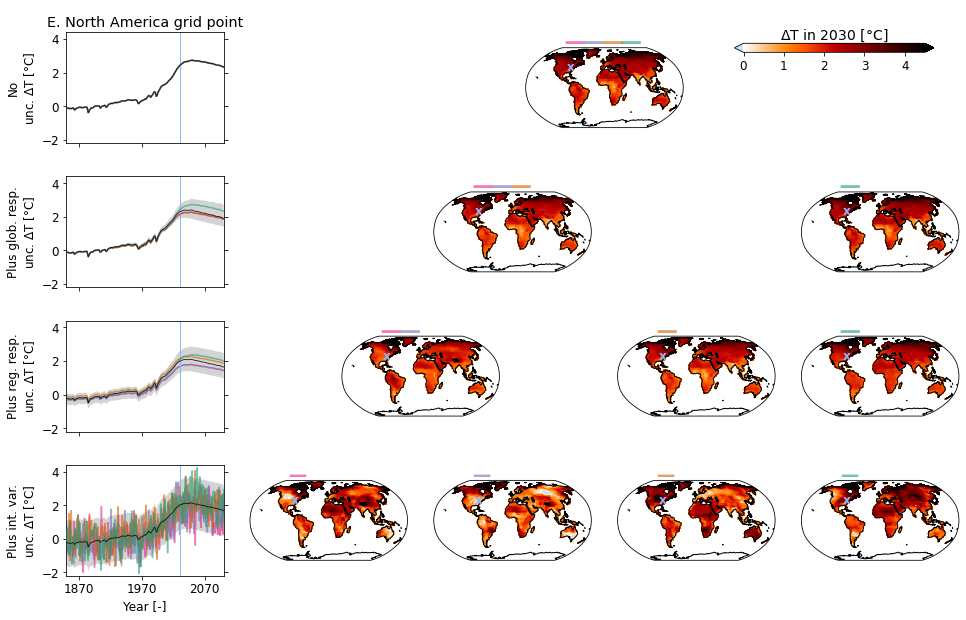

<IPython.core.display.Javascript object>

In [52]:
print('Plot the sources of uncertainty figure, i.e., raw Figure 2')
scen='h-ssp119'
plt.figure(figsize=(16, 10))
plt.rcParams.update({'mathtext.default':'it'}) 
fs = 12
plt.rcParams.update({'font.size':fs})

grid = plt.GridSpec(4, 10, wspace=0.4, hspace=0.3)


for l in np.arange(4):
    unc=uncs[l]
    name = names[l]
    m = 0
    plot_ts()
    if l == 0:
        plt.title('E. North America grid point')
    if l != 3:
        plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
    else:
        plt.xlabel('Year [-]')
l=3
unc = uncs[l]
k = 2
for m in np.arange(4):
    ax1 = plt.subplot(grid[l,k:k+2], projection=ccrs.Robinson(central_longitude=0))
    plot_map()
    plt.text(x=0.25,y=1.05,s='_',color=cols[m],fontsize=fs+20,transform=ax1.transAxes,verticalalignment='bottom',alpha=0.6)

    k+=2
    
l=2
unc = uncs[l]    
m = 0
ax1 = plt.subplot(grid[l,3:5], projection=ccrs.Robinson(central_longitude=0))
plt.text(x=0.25,y=1.05,s='_',color=cols[m],fontsize=fs+25,transform=ax1.transAxes,verticalalignment='bottom',alpha=0.6)
m = 1
plt.text(x=0.37,y=1.05,s='_',color=cols[m],fontsize=fs+25,transform=ax1.transAxes,verticalalignment='bottom',alpha=0.6)
plot_map()

m = 2
ax1 = plt.subplot(grid[l,6:8], projection=ccrs.Robinson(central_longitude=0))
plot_map()
plt.text(x=0.25,y=1.05,s='_',color=cols[m],fontsize=fs+25,transform=ax1.transAxes,verticalalignment='bottom',alpha=0.6)

m = 3
ax1 = plt.subplot(grid[l,8:10], projection=ccrs.Robinson(central_longitude=0))
plot_map()
m = 3
plt.text(x=0.25,y=1.05,s='_',color=cols[m],fontsize=fs+25,transform=ax1.transAxes,verticalalignment='bottom',alpha=0.6)


l=1
unc = uncs[l]
m=1
ax1 = plt.subplot(grid[l,4:6], projection=ccrs.Robinson(central_longitude=0))
plot_map()
m = 0
plt.text(x=0.25,y=1.05,s='_',color=cols[m],fontsize=fs+25,transform=ax1.transAxes,verticalalignment='bottom',alpha=0.6)
m = 1
plt.text(x=0.37,y=1.05,s='_',color=cols[m],fontsize=fs+25,transform=ax1.transAxes,verticalalignment='bottom',alpha=0.6)
m = 2
plt.text(x=0.49,y=1.05,s='_',color=cols[m],fontsize=fs+25,transform=ax1.transAxes,verticalalignment='bottom',alpha=0.6)



m=3
ax1 = plt.subplot(grid[l,8:10], projection=ccrs.Robinson(central_longitude=0))
plot_map()
plt.text(x=0.25,y=1.05,s='_',color=cols[m],fontsize=fs+25,transform=ax1.transAxes,verticalalignment='bottom',alpha=0.6)


l=0
unc = uncs[l]
m=1
ax1 = plt.subplot(grid[l,5:7], projection=ccrs.Robinson(central_longitude=0))
mesh_1=plot_map()
m = 0
plt.text(x=0.25,y=1.05,s='_',color=cols[m],fontsize=fs+25,transform=ax1.transAxes,verticalalignment='bottom',alpha=0.6)
m = 1
plt.text(x=0.37,y=1.05,s='_',color=cols[m],fontsize=fs+25,transform=ax1.transAxes,verticalalignment='bottom',alpha=0.6)
m = 2
plt.text(x=0.49,y=1.05,s='_',color=cols[m],fontsize=fs+25,transform=ax1.transAxes,verticalalignment='bottom',alpha=0.6)
m = 3
plt.text(x=0.61,y=1.05,s='_',color=cols[m],fontsize=fs+25,transform=ax1.transAxes,verticalalignment='bottom',alpha=0.6)


plt.subplot(grid[l,7:10]) 
plt.axis('off')
cb=plt.colorbar(mesh_1,orientation='horizontal',extend='both', shrink = 0.8,fraction=0.9)
cb.set_label(f'$\Delta$T in {time[idx_t]} [°C]',fontsize=fs+2)
cb.ax.xaxis.set_label_position('top')



#plt.savefig(cfg.dir_plots+f'uncertainties_gp{idx_gp}_map{time[idx_t]}_scen{scen}.png' ,dpi=200 ,bbox_inches='tight')
#plt.savefig(cfg.dir_plots+f'uncertainties_gp{idx_gp}_map{time[idx_t]}_scen{scen}.pdf' ,dpi=200 ,bbox_inches='tight')
